<a href="https://colab.research.google.com/github/SomaKorada07/END2.0/blob/main/Session%205/Session_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np

In [21]:
df = pd.read_csv('/content/datasetSentences.txt', sep = '\t', header = 0)
df.head()

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."


In [2]:
df.columns

Index(['sentence_index', 'sentence'], dtype='object')

In [3]:
len(df['sentence_index']), len(df['sentence'])

(11855, 11855)

In [4]:
df_labels = pd.read_csv('/content/sentiment_labels.txt', sep = '|', header = 0)
df_labels.head()

,phrase ids,sentiment values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


In [5]:
len(df_labels)

239232

In [6]:
df_dict = pd.read_csv('/content/dictionary.txt', sep = '|', header = None)
df_dict.head()

,0,1
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936


In [7]:
df_dict.columns

Int64Index([0, 1], dtype='int64')

In [8]:
type(df_dict[0]), type(df_dict[1])

(pandas.core.series.Series, pandas.core.series.Series)

In [9]:
df_dict.rename(columns = {0: 'phrase', 1: 'phrase ids'}, inplace = True)

In [10]:
# pd.to_numeric(df_dict[1], downcast='integer')

In [11]:
df_dict.head()

,phrase,phrase ids
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936


In [12]:
df_target = pd.merge(df_labels, df_dict, how = 'inner', left_on = 'phrase ids', right_on = 'phrase ids')

In [13]:
df_target.head()

,phrase ids,sentiment values,phrase
0,0,0.50000,!
1,1,0.50000,'
2,2,0.44444,' (
3,3,0.50000,' ( the cockettes
4,4,0.42708,' ( the cockettes )


In [14]:
common_sentences = df[df['sentence'].isin(df_target['phrase'])]

In [15]:
common_sentences

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."
...,...,...
11850,11851,A real snooze .
11851,11852,No surprises .
11852,11853,We 've seen the hippie-turned-yuppie plot befo...
11853,11854,Her fans walked out muttering words like `` ho...


In [16]:
def sentence_exists(input_sentence):
    matching_phrase = df_target[df_target["phrase"] == input_sentence]["phrase ids"].values
    default_series = pd.Series({"phrase ids":-1000, "sentiment values": -1000}) ## For cases where we dont find a full sentence match
    if(len(matching_phrase)) > 0:
        phrase_id = np.int(matching_phrase[0])
        sentiment_value = df_target[df_target["phrase ids"] == matching_phrase[0]]["sentiment values"].values[0]
        default_series = pd.Series({"phrase ids":phrase_id, "sentiment values": sentiment_value})

    return default_series

In [22]:
common_sentences.loc[:, ["phrase ids", "sentiment values"]] =  common_sentences.loc[:,"sentence"].apply(sentence_exists)

In [23]:
common_sentences.head()

,sentence_index,sentence,phrase ids,sentiment values
0,1,The Rock is destined to be the 21st Century 's...,226166.0,0.69444
1,2,The gorgeously elaborate continuation of `` Th...,226300.0,0.83333
2,3,Effective but too-tepid biopic,13995.0,0.51389
3,4,If you sometimes like to go to the movies to h...,14123.0,0.73611
4,5,"Emerges as something rare , an issue movie tha...",13999.0,0.86111


In [24]:
pd.to_numeric(common_sentences['phrase ids'], downcast='integer')

0        226166
1        226300
2         13995
3         14123
4         13999
          ...  
11850    222071
11851    225165
11852    226985
11853    223632
11854    224044
Name: phrase ids, Length: 11286, dtype: int32

In [25]:
common_sentences.head()

,sentence_index,sentence,phrase ids,sentiment values
0,1,The Rock is destined to be the 21st Century 's...,226166.0,0.69444
1,2,The gorgeously elaborate continuation of `` Th...,226300.0,0.83333
2,3,Effective but too-tepid biopic,13995.0,0.51389
3,4,If you sometimes like to go to the movies to h...,14123.0,0.73611
4,5,"Emerges as something rare , an issue movie tha...",13999.0,0.86111


In [27]:
common_sentences.shape

(11286, 4)

# Training and test dataset
After applying above techiniques we get a combined DataFrame that has the following fields:

*   sentence_index : Original sentence_index in the datasetSentences.txt
*   sentence: The actual sentence
*   Phrase_Id: The Phrase_Id used for mapping/retrieving sentiment score
*   Sentiment_Score: Actual Sentiment score for the sentence

Now we split the DataFrame into Training and Test Dataframes. Note that we are not using the recommended train/ dev /test splits from the dataset.

In [28]:
train_df = common_sentences.sample(frac = 0.8) 
test_df = common_sentences[~common_sentences.sentence_index.isin(train_df.sentence_index)]

In [29]:
train_df.shape, test_df.shape

((9029, 4), (2257, 4))

In [30]:
train_df.to_csv("StanfordTrain.csv", index=False, sep="|")
test_df.to_csv("StanfordTest.csv", index=False, sep="|")

# Data Augmentation Techniques

## **Random Swap**
The random swap augmentation takes a sentence and then swaps words within it n times, with each iteration working on the previously swapped sentence. Here we sample two random numbers based on the length of the sentence, and then just keep swapping until we hit n.

In [31]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

For more on this please go through this [paper](https://arxiv.org/pdf/1901.11196.pdf).

##**Back Translation**

Another popular approach for augmenting text datasets is back translation. This involves translating a sentence from our target language into one or more other languages and then translating all of them back to the original language. We can use the Python library googletrans for this purpose. 

In [33]:
!pip install googletrans==3.1.0a0

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 1.0MB 3.4MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 71kB 4.1MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-cp37-none-any.whl size=16368 sha256=1fa0dfa5c94fe69534d1353300028114e73d3c599556bc7a944ab26532603b35
  Stored in directory: /root/.cache/pip/wheels/27/7a/a0/aff3babbb775549ce6813cb8fa7ff3c0848c4dc62c20f8fdac
Successfully built googletrans


In [35]:
import random
import googletrans
#import googletrans.Translator as Translator

translator = googletrans.Translator()
sentence = ['The dog slept on the rug', 'ran lazily']

available_langs = list(googletrans.LANGUAGES.keys()) 
trans_lang = random.choice(available_langs) 
print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")

trans_lang

Translating to urdu


'ur'

In [36]:
sentence = ['The dog slept on the rug']
available_langs = list(googletrans.LANGUAGES.keys()) 
trans_lang = random.choice(available_langs) 
print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")

Translating to swedish


In [37]:
translations = translator.translate(sentence, dest=trans_lang) 
t_text = [t.text for t in translations]
print(t_text)

['Hunden sov på mattan']


In [38]:
translations_en_random = translator.translate(t_text, src=trans_lang, dest='en') 
en_text = [t.text for t in translations_en_random]
print(en_text)

['The dog slept on the carpet']


In [39]:
translator = googletrans.Translator()

def back_translate(sentence):
    available_langs = list(googletrans.LANGUAGES.keys()) 
    trans_lang = random.choice(available_langs) 
    translations = translator.translate(sentence, dest=trans_lang) 
    t_text = [t.text for t in translations]
    translations_en_random = translator.translate(t_text, src=trans_lang, dest='en') 
    en_text = [t.text for t in translations_en_random]
    return en_text

In [40]:
back_translate([common_sentences.iloc[0].sentence])

["The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."]


## **Data Augmentation**
We use the EDA techniques referred in this [code](https://github.com/jasonwei20/eda_nlp). Our parameters for augmentation are as follows:

*   Num_aug = 5 i.e 5 augmented sentences
*   alpha_rs=0.2 i.e 20% percent of words in each sentence to be swapped
*   alpha_rd=0.2 i.e 20% percent of words in each sentence to be dropped


In [61]:
import random
from random import shuffle
random.seed(1)

#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

#for the first time you use wordnet
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

In [62]:
def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1

	#sr
	if (alpha_sr > 0):
		n_sr = max(1, int(alpha_sr*num_words))
		for _ in range(num_new_per_technique):
			a_words = synonym_replacement(words, n_sr)
			augmented_sentences.append(' '.join(a_words))

	#ri
	if (alpha_ri > 0):
		n_ri = max(1, int(alpha_ri*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_insertion(words, n_ri)
			augmented_sentences.append(' '.join(a_words))

	#rs
	if (alpha_rs > 0):
		n_rs = max(1, int(alpha_rs*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_swap(words, n_rs)
			augmented_sentences.append(' '.join(a_words))

	#rd
	if (p_rd > 0):
		for _ in range(num_new_per_technique):
			a_words = random_deletion(words, p_rd)
			augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	augmented_sentences.append(sentence)

	return augmented_sentences

In [66]:
train_df.head()

,sentence_index,sentence,phrase ids,sentiment values
6681,6682,"It 's got the brawn , but not the brains .",106881.0,0.31944
8685,8686,Just one problem : Fish out of water usually d...,146972.0,0.44444
7541,7542,"A very long movie , dull in stretches , with e...",143420.0,0.19444
3535,3536,Director Juan Jose Campanella could have turne...,223149.0,0.93056
1566,1567,Writer-director 's Mehta 's effort has tons of...,47695.0,0.83333


In [67]:
# from eda import *
simpler_series_df = train_df.copy()
empty_series = { col:[] for col in train_df.columns.values}
my_new_df = pd.DataFrame(data=empty_series)

In [68]:
simpler_series_df = train_df

In [69]:
simpler_series_df.head()

,sentence_index,sentence,phrase ids,sentiment values
6681,6682,"It 's got the brawn , but not the brains .",106881.0,0.31944
8685,8686,Just one problem : Fish out of water usually d...,146972.0,0.44444
7541,7542,"A very long movie , dull in stretches , with e...",143420.0,0.19444
3535,3536,Director Juan Jose Campanella could have turne...,223149.0,0.93056
1566,1567,Writer-director 's Mehta 's effort has tons of...,47695.0,0.83333


In [72]:
max_sentence_ids = simpler_series_df.sentence_index.max()
alpha_sr = 0.0
alpha_ri=0.0
alpha_rs=0.2
alpha_rd=0.2
num_aug=5

for idx in simpler_series_df.itertuples():
    # print(idx)
    sentence = idx.sentence
    aug_sentences = eda(sentence, alpha_sr=alpha_sr, alpha_ri=alpha_ri, alpha_rs=alpha_rs, p_rd=alpha_rd, num_aug=num_aug)
    for aug_sentence in aug_sentences:
        max_sentence_ids += 1
        my_new_df.loc[len(my_new_df)] = [max_sentence_ids,aug_sentence, np.int(idx._3), idx._4 ]

In [73]:
my_new_df

,sentence_index,sentence,phrase ids,sentiment values
0,11855.0,it s got brains brawn but not the the,106881.0,0.31944
1,11856.0,it s got the but not the brains,106881.0,0.31944
2,11857.0,it s got but not the,106881.0,0.31944
3,11858.0,it s got the brawn the not but brains,106881.0,0.31944
4,11859.0,it s got the brawn but not the brains,106881.0,0.31944
...,...,...,...,...
48915,56995.0,there nothing exactly wrong here but there s n...,188845.0,0.33333
48916,56996.0,there s nothing exactly wrong here that s near...,188845.0,0.33333
48917,56997.0,there s nothing nearly wrong that but there s ...,188845.0,0.33333
48918,56998.0,there s nothing exactly wrong but there s not ...,188845.0,0.33333


In [74]:
my_new_df = my_new_df.sample(frac = 1)

In [75]:
my_new_df.to_csv("StanfordAugmented.csv", index = False, sep = "|")

In [76]:
my_new_df = my_new_df.append(train_df, ignore_index = True)


## **Augmenting with Back_Translate**
In this method we make a translate from source English sentence to a sentence in random language and then back into English. We create a dataframe of around 4000 samples and append it back to the dataset

In [77]:
translator = googletrans.Translator()

def back_translate(sentence):
    available_langs = list(googletrans.LANGUAGES.keys()) 
    trans_lang = random.choice(available_langs) 
    translations = translator.translate(sentence, dest=trans_lang) 
    t_text = [t.text for t in translations]
    translations_en_random = translator.translate(t_text, src=trans_lang, dest='en') 
    en_text = [t.text for t in translations_en_random]
    return en_text

In [79]:
max_sentence_ids=simpler_series_df["sentence_index"].max()
for idx in my_new_df[2000:6000].itertuples():
    sentence = idx.sentence
    aug_sentence = back_translate([sentence])[0]
    max_sentence_ids += 1
    simpler_series_df.loc[len(simpler_series_df)] = [max_sentence_ids,aug_sentence, np.int(idx._3), idx._4]

In [80]:
simpler_series_df.to_csv("StanfordTranslate.csv", index = False, sep = "|")

In [81]:
my_new_df = my_new_df.append(train_df, ignore_index = True)

## **Range expansion**
The sentiment scores are floats between [0,1] so we convert this to equivalent integers between 0 and 24(i.e 25 different classes)

In [84]:
my_new_df["label"] = 0

def quantize_predictions(score_val):
    return np.floor(score_val * 24)

my_new_df.loc[:,"label"] = my_new_df.loc[:,"sentiment values"].apply(quantize_predictions)

In [86]:
my_new_df["sentence_index"] = my_new_df["sentence_index"].astype('int')
my_new_df["Phrase_Id"] = my_new_df["phrase ids"].astype('int')
my_new_df["label"] = my_new_df["label"].astype('int')

In [87]:
my_new_df

,sentence_index,sentence,phrase ids,sentiment values,label,Phrase_Id
0,42477,an enthralling aesthetic experience one that s...,44483.0,0.819440,19,44483
1,45093,the entire film big excuse to one lewd after a...,226240.0,0.069444,1,226240
2,18650,so only than undercover time also funny if mor...,26229.0,0.819440,19,26229
3,35622,holofcener rejects solutions to life s messine...,66043.0,0.847220,20,66043
4,12393,nicole holofcener the lovely and amazing from ...,107994.0,0.847220,20,107994
...,...,...,...,...,...,...
66974,11261,"Certainly not a good movie , but it was n't ho...",183042.0,0.305560,7,183042
66975,1234,A warm but realistic meditation on friendship ...,24505.0,0.833330,19,24505
66976,5968,With a tone as variable as the cinematography ...,111193.0,0.208330,4,111193
66977,9206,"There 's nothing exactly wrong here , but ther...",188845.0,0.333330,7,188845


In [88]:
my_new_df.to_csv("StanFullTrain.csv", index = False, sep = "|")

## **Training**

In [93]:
# Import Library
import pandas as pd
import numpy as np
import random
import torch, torchtext
from torchtext.legacy import data
import matplotlib.pyplot as plt


# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [90]:
my_new_df = pd.read_csv("StanFullTrain.csv", sep="|")

(array([ 423., 1453., 1239., 2075., 4497., 2671., 4474., 4892., 1962.,
        3089., 3674., 1370., 3052., 3207., 1909., 2751., 4822., 2907.,
        4556., 5590., 1804., 2827., 1285.,  277.,  173.]),
 array([ 0.  ,  0.96,  1.92,  2.88,  3.84,  4.8 ,  5.76,  6.72,  7.68,
         8.64,  9.6 , 10.56, 11.52, 12.48, 13.44, 14.4 , 15.36, 16.32,
        17.28, 18.24, 19.2 , 20.16, 21.12, 22.08, 23.04, 24.  ]),
 <a list of 25 Patch objects>)

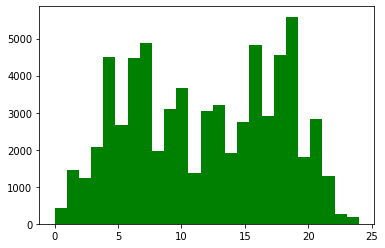

In [91]:
num_bins = 25

colors = ['green'] 
plt.hist(my_new_df.label, density = False, bins = 25, histtype = 'bar', color = colors, label = colors)

In [94]:
Sentence = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [95]:
fields = [('sentence', Sentence),('label',Label)]

In [ ]:
example = [data.Example.fromlist([my_new_df.sentence[i],my_new_df.label[i]], fields) for i in range(my_new_df.shape[0])] 

stanTreeDataset = data.Dataset(example, fields)
(train, valid) = stanTreeDataset.split(split_ratio=[0.85, 0.15], random_state=random.seed(SEED))
Sentence.build_vocab(train)
Label.build_vocab(train)

In [ ]:
(len(train), len(valid))

In [ ]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

In [ ]:
next(iter(train_iterator))

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

## **Model Architecture**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [ ]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = len(my_new_df.label.unique())
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

## Model Training & Evaluation

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()  
        #print(predictions)
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            #print(predictions)
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 100
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    #train_loss = train(model, train_iterator, optimizer, criterion)


    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    #valid_loss = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tEpoch: {epoch} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    #categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    #return categories[pred.item()]
    return pred.item()

In [ ]:
classify_tweet("A valid explanation for why Trump won't let women on the golf course.")

In [ ]:
classify_tweet("The movie had zilch character, nada screenplay, zero action scenes, almost negligible thougts")

In [ ]:
classify_tweet("5 minutes into the movie, you feel you want to runaway but eventually the movie catches on and does a great job")